# Step 3 - Crawling the Web with Scrapy



## Basic structure of an HTML document

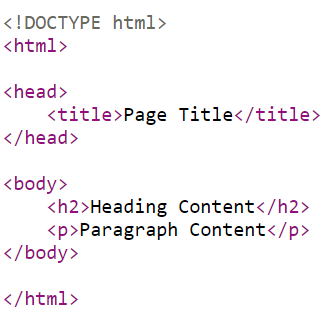

Source: https://www.geeksforgeeks.org/html-course-structure-of-an-html-document/


## HTML syntax

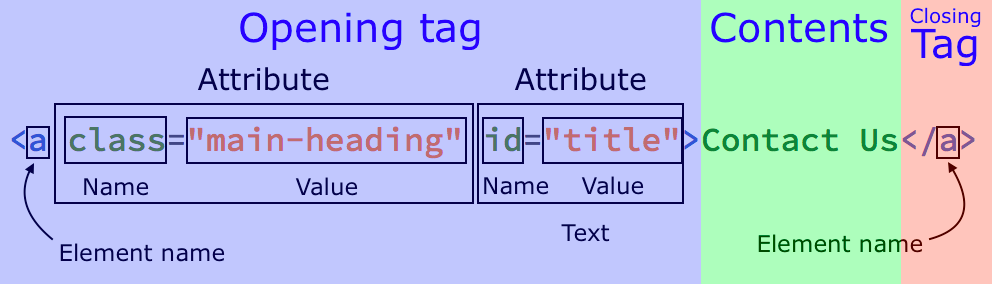

Source: https://codetheweb.blog/html-syntax/

In the context of web scraping, we are usually interested in tags and class attributes (sometimes also IDs). As an example in this section, we will use the https://eng.lsm.lv/ website.

First, let's study the structure of the main page using Developer Tools and identify the most interesting elements on that page:


*   Each article thumbnail is in the container with the tag `<article>` and the class `thumbnail`
*   The title for each article is in the `<a>` tag with the class `thumbnail__caption`. The URL for the article itself is also contained there, in the `href` attribute
*   Some of the thumbnails have the category assigned. The category is inside `<span>` tag with the `thumbnail__category` class.


## Exercise

Study the structure of any article on https://eng.lsm.lv/ website. Identify elements of the page that we might want to scrape, and their respective tags and classes.

## Scrapy

Scrapy is a web scraping framework for Python. In this section, we will extract some data from the LSM website using *spider* - a Scrapy project. But before we start scraping, it is a good idea to check *robots.txt* file: https://eng.lsm.lv/robots.txt 

In [ ]:
# install Scrapy
!pip install Scrapy

In [ ]:
import requests
from scrapy.http import TextResponse # before writing a spider, it is usually a good idea to try to scrape some information from the page manually

res = requests.get('https://eng.lsm.lv/article/society/environment/residents-protest-proposed-catalytic-converter-processing-plant.a466732/')
response = TextResponse(res.url, body=res.text, encoding='utf-8')

response.text

In [ ]:
# article-title
title = response.css('h1.article-title::text').get()
print(title)
# article-lead
subtitle = response.css('h2.article-lead::text').get()
print(subtitle)
# article__body
body = response.css('div.article__body').get()
print(body)

In [ ]:
article_text = ''
for paragraph in response.css('div.article__body').css('p::text').getall():
  paragraph = paragraph.replace(u'\xa0', u' ')
  article_text = article_text + paragraph
article_text

As we now know all the fields we want to extract, we can create a spider. First, you should initialize a new spider:

In [ ]:
!scrapy startproject lsmSpider

To create a crawler, you should add a new file inside *spiders* directory at lsmSpider/lsmSpider/spiders/article.py. 

In [ ]:
import os
# change working directories
os.chdir('/content/lsmSpider/lsmSpider/spiders')

In [ ]:
%%writefile -a article.py
import scrapy

class ArticleSpider(scrapy.Spider):
  name='article'
  start_urls = ['https://eng.lsm.lv/article/society/environment/residents-protest-proposed-catalytic-converter-processing-plant.a466732/']

  def parse(self, response):
    title = response.css('h1.article-title::text').get()
    subtitle = response.css('h2.article-lead::text').get()

    article_text = ''
    for paragraph in response.css('div.article__body').css('p::text').getall():
      paragraph = paragraph.replace(u'\xa0', u' ')
      article_text = article_text + paragraph
    
    print('Title is: ' + title)
    print('Subtitle is: ' + subtitle)
    print('Article text is: ' + article_text)

In [ ]:
!scrapy runspider article.py # note, that you should be in the same directory where article.py is

## Exercise

In this exercise, we will try to scrape Wikipedia. 

1.   Check the *robots.txt* file on Wikipedia. Is it allowed to scrape Wikipedia? What else is interesting in this file?
2.   Select an article you will scrape (e.g. https://en.wikipedia.org/wiki/Lion%27s_mane_jellyfish)
3.   Initialize a new spider (Scrapy project) called wikiSpider. There, create a
spider article.py 
4.   Extract the title of this article
5.   Try to add more Wikipedia pages to the `start_requests` urls and check whether your scraper works with other Wikipedia pages.

## A brief introduction to XPath

Besides CSS, Scrapy selectors also support using XPath expressions. XPath expressions are generally more powerful than CSS selectors, but they are more difficult to construct. The alternative way to select the title, the subtitle and the article body from the LSM website would be:

```python
# article-title
title = response.xpath('//h1[@class="article-title"]/text()').get()
print(title)
# article-lead
subtitle = response.xpath('//h2[@class="article-lead"]/text()').get()
print(subtitle)
# article__body
article_text = ''
for paragraph in response.xpath('//div[@class="article__body"]//p'):
  paragraph = paragraph.xpath('string()').get()
  paragraph = paragraph.replace(u'\xa0', u' ')
  article_text = article_text + paragraph
print(article_text)
```

## Creating Items

Items in Scrapy are  defined by Item classes. An Item class is just a regular Python class that defines the fields (keys) for the items.

Fields are defined as class variables. The field names will be used as the column names of the CSV, Excel and JSON output.

To help organize the collected data, lets modify the LsmspiderItem object in our lsmSpider project. Usually Item objects are stored in the `items.py` file.

In [ ]:
os.chdir('/content/lsmSpider/lsmSpider')

In [ ]:
%%writefile items.py
import scrapy

class LsmspiderItem(scrapy.Item):
  title = scrapy.Field()
  subtitle = scrapy.Field()
  article_text = scrapy.Field()

And then we should modify `articles.py` file:

In [ ]:
%%writefile spiders/article.py
import scrapy
from lsmSpider.items import LsmspiderItem

class ArticleSpider(scrapy.Spider):
  name='article'
  start_urls = ['https://eng.lsm.lv/article/society/environment/residents-protest-proposed-catalytic-converter-processing-plant.a466732/',
                'https://eng.lsm.lv/article/culture/food-drink/traditional-and-national-latvian-foods-whats-the-difference.a466155/',
                'https://eng.lsm.lv/article/society/education/free-school-lunches-will-be-rare-this-year-in-latvia.a466298/']

  def parse(self, response):
    article = LsmspiderItem()
    article['title'] = response.css('h1.article-title::text').get()
    article['subtitle'] = response.css('h2.article-lead::text').get()
    article_text = ''
    for paragraph in response.css('div.article__body').css('p::text').getall():
      paragraph = paragraph.replace(u'\xa0', u' ')
      article_text = article_text + paragraph
    article['article_text'] = article_text
    return article

Now launch the spider and see how the output changed:

In [ ]:
os.chdir('/content/lsmSpider/lsmSpider/spiders')
!scrapy runspider article.py

Now we can also save the output as a CSV, JSON or XML:

In [ ]:
!scrapy runspider article.py -o articles.csv -t csv
!scrapy runspider article.py -o articles.json -t json
!scrapy runspider article.py -o articles.xml -t xml

## Following links

For the crawler it is necessary to be able to extract links from the pages, follow them, and scrape the information from them. In that example, we will extract links from the main LSM page and scrape information for that articles.

For that, we will crate a new spider `lsmMain.py` in `spiders` folder:

In [ ]:
%%writefile lsmMain.py
import scrapy
from lsmSpider.items import LsmspiderItem

class LsmMainSpider(scrapy.Spider):
  name = 'lsmMain'
  allowed_domains = ["eng.lsm.lv"]

  start_urls = ['https://eng.lsm.lv/']

  def parse(self, response):
    for href in response.css('a.thumbnail__caption::attr("href")'):
      url = response.urljoin(href.get())
      yield scrapy.Request(url, callback = self.parse_article_content)

  def parse_article_content(self, response):
    article = LsmspiderItem()
    article['title'] = response.css('h1.article-title::text').get()
    article['subtitle'] = response.css('h2.article-lead::text').get()
    article_text = ''
    for paragraph in response.css('div.article__body').css('p::text').getall():
      paragraph = paragraph.replace(u'\xa0', u' ')
      article_text = article_text + paragraph
    article['article_text'] = article_text
    yield article

In [ ]:
!scrapy runspider lsmMain.py -o lsmMain.csv -t csv

## Download delay

Usually, we want to introduce some delay between request. It could be done by modifying DOWNLOAD_DELAY setting in the `settings.py` file. By default, there is no delay, so we can set make spider to wait a bit between requests by modifying DOWNLOAD_DELAY setting.

E.g. `DOWNLOAD_DELAY = 3` will wait for 3 seconds between requests.

## Exercise

In this exercise, you will scrape the Estonian news website: https://news.err.ee/

The task is to create a spider to collect all links for the articles on the main page, then extract their title, publication date and the lead section of the article (in bold). Create a separate Scrapy project for that task. Don't forget to think about Item structure for the extracted data.

Bonus task: extract also tags below the article body.



## Bonus

### Going to the next page with Scrapy

In search results, for example, you may want to follow all result pages. This is how the spider may look which will follow the link to the next page, extracting data from it (taken from the [official Scrapy tutorial](https://doc.scrapy.org/en/latest/intro/tutorial.html)):

```python
import scrapy


class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = ['https://quotes.toscrape.com/page/1/']

    def parse(self, response):
        for quote in response.css('div.quote'):
            yield {
                'text': quote.css('span.text::text').get(),
                'author': quote.css('small.author::text').get(),
                'tags': quote.css('div.tags a.tag::text').getall(),
            }

        next_page = response.css('li.next a::attr(href)').get()
        if next_page is not None:
            next_page = response.urljoin(next_page)
            yield scrapy.Request(next_page, callback=self.parse)
```

### `IMPORTXML` function in Google Sheets

Similar to the `IMPORTHTML` function we looked at in the STEP1, you can use the `IMPORTXML` function in Google Sheets to extract not only tabular data or list, but any information on the web page.

To do that, you need to utilize the XPATH expression.

To extract all links from the LSM page with Scrapy, we used the following CSS selector:

```
response.css('a.thumbnail__caption::attr("href")')
```

We can translate it to the XPATH expression:

```
response.xpath('//a[@class="thumbnail__caption"]/@href')
```

Now, the syntax to use the `IMPORTXML` function is:

```
=IMPORTXML(url, xpath_query)
```

So, to extract all links from the LSM page, we can use the following formula in Google Sheets:

```
=IMPORTXML("https://eng.lsm.lv/", "//a[@class='thumbnail__caption']/@href")
```

### [Zyte](https://zyte.com/)

There are services, that handle the scraping of the web pages for you. One of them is Zyte.

Zyte can host your Scrapy projects and run them automatically, but also there is a service, that can automatically extract news from the news websites. It uses AI to find relevant tags and class names on the webpages, and then it can extract the data from the webpages.



## What to do next?

If you are interested in more advanced topics, there is what you can do:

1.  Check the [Scrapy documentation](https://doc.scrapy.org/en/latest/intro/tutorial.html)
2.  Learn to avoid scraping traps, and avoid being blocked by the website. Learn how to adjust your request headers (e.g. `User-Agent`) to avoid being blocked.
3.  Learn image processing and text regognition and how to use it in Scrapy. That can help you to extract data from images, and to avoid some CAPTCHAs. Some of the best image processing libraries are:
    *  [Pillow](https://pillow.readthedocs.io/en/stable/)
    *  [Tesseract](https://tesseract.readthedocs.io/en/latest/)
